# VQD Client (Package-Only)

This notebook is a **pure client** of the `vqe` package implementation of:

**Variational Quantum Deflation (VQD)**:
- Solve ground state with VQE-like optimization
- Then sequentially solve excited states with a deflation penalty:
$$
\mathcal{L}_n(\theta_n) = \langle H\rangle_{\theta_n} + \beta \sum_{k<n} \Omega(\psi_k,\psi_n)
$$
where $\Omega$ is:
- noiseless: $|\langle\psi_k|\psi_n\rangle|^2$
- noisy: $\mathrm{Tr}(\rho_k\rho_n)$


In [ ]:
from __future__ import annotations

from vqe.vqd import run_v2dR

## Choose a molecule and run configuration

In [ ]:
molecule = "H2"  # "H2", "H3+", "LiH", "H2O"
num_states = 2

ansatz_name = "StronglyEntanglingLayers"  # "UCCSD", "UCC-D", "UCC-S", "RY-CZ", "StronglyEntanglingLayers", "TwoQubit-RY-CNOT", "Minimal"
optimizer_name = "Adam"

steps = 250
stepsize = 0.2
seed = 0

# Noise controls
noisy = False
depolarizing_prob = 0.0
amplitude_damping_prob = 0.0


## Run VQD

💾 Saved VQD run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__VQD(StronglyEntanglingLayers)_2states__Adam__VQE__noiseless__s0__89db8b50ffa3.json


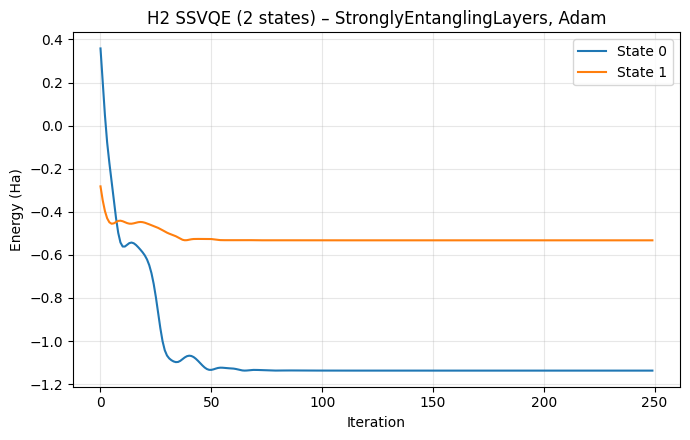

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ssvqe_conv_StronglyEntanglingLayers_Adam_s0.png


In [ ]:
result = run_vqd(
    molecule=molecule,
    num_states=num_states,
    beta=10.0,               # final beta
    beta_start=0.0,          # start at 0
    beta_ramp="cosine",      # smooth
    beta_hold_fraction=0.1,  # optional short warmup
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=noisy,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    plot=True,
    force=True,
)


## Inspect final energies

In [16]:
energies_per_state = result["energies_per_state"]
final_energies = [traj[-1] for traj in energies_per_state]
for k, E in enumerate(final_energies):
    print(f"State {k}: final energy = {E:.10f} Ha")

State 0: final energy = -1.1372701749 Ha
State 1: final energy = -0.5324790143 Ha
